In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

file_jan = '/mnt/data06/andyxia/data/Jan/Jan_bomb_data.json'
file_feb = '/mnt/data06/andyxia/data/Feb/Feb_bomb_data.json'
file_mar = '/mnt/data06/andyxia/data/Mar/Mar_bomb_data.json'
file_apr = '/mnt/data06/andyxia/data/Apr/Apr_bomb_data.json'
file_may = '/mnt/data06/andyxia/data/May/May_bomb_data.json'
file_jun = '/mnt/data06/andyxia/data/Jun/Jun_bomb_data.json'
file_jul = '/mnt/data06/andyxia/data/Jul/Jul_bomb_data.json'
file_aug = '/mnt/data06/andyxia/data/Aug/Aug_bomb_data.json'
file_sep = '/mnt/data06/andyxia/data/Sep/Sep_bomb_data.json'
file_oct = '/mnt/data06/andyxia/data/Oct/Oct_bomb_data.json'
file_nov = '/mnt/data06/andyxia/data/Nov/Nov_bomb_data.json'
file_dec = '/mnt/data06/andyxia/data/Dec/Dec_bomb_data.json'
df1 = pd.read_json(file_jan)
df2 = pd.read_json(file_feb)
df3 = pd.read_json(file_mar)
df4 = pd.read_json(file_apr)
df5 = pd.read_json(file_may)
df6 = pd.read_json(file_jun)
df7 = pd.read_json(file_jul)
df8 = pd.read_json(file_aug)
df9 = pd.read_json(file_sep)
df10 = pd.read_json(file_oct)
df11= pd.read_json(file_nov)
df12 = pd.read_json(file_dec)

### Replace with the right directory path ###
df1 = pd.read_json('Path to your file')
df2 = pd.read_json('Path to your second file')
### Put all files in this list. (Works with a single file)
demofiles=[df1, df2]

In [4]:
def sync_team(player_stat):

    # Use default values to fill in any missing attributes for the player
    default_values = {
        'is_alive': False, 'hp': 0, 'armor': 0, 'equipment_value': 0, 'cash': 0,
        'cash_spend_this_round': 0, 'round_damage': 0, 'primary_weapon': 'None',
        'secondary_weapon': 'None', 'active_weapon_category': 'None',
        'grenades_left': 0, 'flashes_left': 0, 'smokes_left': 0, 'molotovs_left': 0,
        'total_kills': 0, 'round_kills': 0, 'total_deaths': 0, 'velocityX': 0,
        'velocityY': 0, 'velocityZ': 0, 'viewX': 0, 'viewY': 0, 'callout': 'None',
        'average_damage_per_round': 0, 'amount_spent': 0
    }
    standardized_stat = {key: player_stat.get(key, default_values[key]) for key in default_values}
    return standardized_stat

def add_name(stat, name):
    updated_stat = {f'{name}_{key}': value for key, value in stat.items()}
    # print(type(updated_stat))
    return updated_stat

def read(files):
    stats=[]
    counter=0
    for df in files:
        data_array=np.array(df)
        # print(data_array)
        for entry in data_array:
            # print(entry[0])
            if entry[0]!='error set':
                for value in entry:
                    if isinstance(value,dict):
                        tplayercount=0
                        ctplayercount=0
                        stat=[]
                        if value['T']['living_players'] is not None:
                            for player in value['T']['living_players']:
                                synced=sync_team(player)
                                tplayercount+=1
                                stat.append(add_name(synced,f'T_player{tplayercount}'))
                        if value['T']['dead_players'] is not None:
                            for player in value['T']['dead_players']:
                                player['is_alive']=False
                                player['hp']=0
                                synced=sync_team(player)
                                tplayercount+=1
                                stat.append(add_name(synced,f'T_player{tplayercount}'))
                        if value['CT']['living_players'] is not None:
                            for player in value['CT']['living_players']:
                                synced=sync_team(player)
                                ctplayercount+=1
                                stat.append(add_name(synced,f'CT_player{ctplayercount}'))
                        if value['CT']['dead_players'] is not None:
                            for player in value['CT']['dead_players']:
                                player['is_alive']=False
                                player['hp']=0
                                synced=sync_team(player)
                                ctplayercount+=1
                                stat.append(add_name(synced,f'CT_player{ctplayercount}'))
                        
                        if value['winner']=='T':
                            stat.append({'T_Wins':1})
                        else:
                            stat.append({'T_Wins':0})
                        if value['bombSite']=='A':
                            stat.append({'bombSite_A':True})
                        else:
                            stat.append({'bombSite_A':False})
                        stats.append(stat)
                        
    return stats

def OHE(stats):
    dummy_col=[]
    for x in range(1,6):
        dummy_col.append(f'T_player{x}_primary_weapon')
        dummy_col.append(f'CT_player{x}_primary_weapon')
        dummy_col.append(f'T_player{x}_secondary_weapon')
        dummy_col.append(f'CT_player{x}_secondary_weapon')
        dummy_col.append(f'T_player{x}_active_weapon_category')
        dummy_col.append(f'CT_player{x}_active_weapon_category')
        dummy_col.append(f'T_player{x}_callout')
        dummy_col.append(f'CT_player{x}_callout')
    flat=[]
    for stat in stats:
        holder={}
        for item in stat:
            holder.update(item)
        flat.append(holder)
    df = pd.DataFrame(flat)
    df = pd.get_dummies(df, columns=dummy_col)
    return df

    

stats=read(demofiles)
# print(stats[0])
df=OHE(stats)


In [5]:
df = df.drop([169, 4556])
df = df.reset_index(drop=True)

for col in df.columns:
    nan_rows = df[col].isna()
    if nan_rows.any():
        print(f"{col} contains NaN at rows:")
        print(nan_rows[nan_rows].index.tolist())

In [6]:
count_class_0 = df['T_Wins'].value_counts()[0]  # less frequent
count_class_1 = df['T_Wins'].value_counts()[1]  # more frequent

# Divide by class
df_class_0 = df[df['T_Wins'] == 0]
df_class_1 = df[df['T_Wins'] == 1]

# Randomly under-sample the majority class (T_Wins = 1)
df_class_1_under = df_class_1.sample(count_class_0)
df_balanced = pd.concat([df_class_0, df_class_1_under], axis=0)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_balanced.head(20)

,T_player1_is_alive,T_player1_hp,T_player1_armor,T_player1_equipment_value,T_player1_cash,T_player1_cash_spend_this_round,T_player1_round_damage,T_player1_grenades_left,T_player1_flashes_left,T_player1_smokes_left,...,CT_player5_callout_Pit,CT_player5_callout_Ramp,CT_player5_callout_ShortStairs,CT_player5_callout_Side,CT_player5_callout_TRamp,CT_player5_callout_TSpawn,CT_player5_callout_TopofMid,CT_player5_callout_TunnelStairs,CT_player5_callout_UnderA,CT_player5_callout_UpperTunnel
0,True,100,100,4150,50,5700,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,True,100,95,4600,12300,500,75,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,True,70,91,4100,3600,0,100,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,True,52,100,4400,350,2550,100,0,1,0,...,False,False,False,False,False,False,False,False,False,False
4,True,100,100,4300,950,4100,70,0,0,0,...,False,False,False,False,False,False,False,False,True,False
5,True,100,95,7350,9150,1100,0,0,2,0,...,False,False,False,False,False,False,False,False,False,False
6,True,100,86,3900,9650,200,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
7,True,84,100,5100,300,4900,0,1,0,0,...,False,False,False,False,False,False,False,False,False,False
8,True,5,65,3900,2350,4800,150,0,0,0,...,True,False,False,False,False,False,False,False,False,False
9,True,96,98,3700,4000,0,20,0,1,0,...,False,False,False,False,False,False,False,False,False,False


In [8]:
X = df_balanced.drop(columns=['T_Wins'])
y = df_balanced['T_Wins']

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.8136762860727729
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82       805
           1       0.83      0.79      0.81       789

    accuracy                           0.81      1594
   macro avg       0.81      0.81      0.81      1594
weighted avg       0.81      0.81      0.81      1594



/nas/home/andyxia/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
X = df.drop(columns=['T_Wins'])
y = df['T_Wins']

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.8572803078896729
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.64      0.70       808
           1       0.88      0.93      0.91      2310

    accuracy                           0.86      3118
   macro avg       0.83      0.79      0.80      3118
weighted avg       0.85      0.86      0.85      3118



/nas/home/andyxia/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
model = DecisionTreeClassifier(max_depth=3, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7867001254705144
              precision    recall  f1-score   support

           0       0.77      0.82      0.80       805
           1       0.81      0.75      0.78       789

    accuracy                           0.79      1594
   macro avg       0.79      0.79      0.79      1594
weighted avg       0.79      0.79      0.79      1594



In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7860727728983689
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79       805
           1       0.79      0.78      0.78       789

    accuracy                           0.79      1594
   macro avg       0.79      0.79      0.79      1594
weighted avg       0.79      0.79      0.79      1594



In [11]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7540777917189461
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.93      0.79       805
           1       0.89      0.57      0.70       789

    accuracy                           0.75      1594
   macro avg       0.79      0.75      0.75      1594
weighted avg       0.79      0.75      0.75      1594



In [17]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model = Sequential([
    layers.Dense(10, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(10, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=1, validation_split=0.1)

y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_labels)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred_labels))
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")


Epoch 1/10


/nas/home/andyxia/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5734/5734 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7824 - loss: 0.4531 - val_accuracy: 0.8323 - val_loss: 0.3849
Epoch 2/10
5734/5734 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8625 - loss: 0.3231 - val_accuracy: 0.8354 - val_loss: 0.3914
Epoch 3/10
5734/5734 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8766 - loss: 0.2843 - val_accuracy: 0.8229 - val_loss: 0.4534
Epoch 4/10
5734/5734 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9001 - loss: 0.2290 - val_accuracy: 0.8056 - val_loss: 0.4769
Epoch 5/10
5734/5734 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9243 - loss: 0.1833 - val_accuracy: 0.7931 - val_loss: 0.5583
Epoch 6/10
5734/5734 ━━━━━━━━━━━━━━━━━━━━ 6s 989us/step - accuracy: 0.9383 - loss: 0.1541 - val_accuracy: 0.8088 - val_loss: 0.6644
Epoch 7/10
5734/5734 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9516 - loss: 0.1197 - val_accuracy: 0.7947 - val_loss: 0.7533
Epoch 8/10
5734/5734 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9576 - loss: 0.1090 - val_ac

In [13]:
from sklearn.svm import SVC
svm_model = SVC(kernel='linear')

svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.8067754077791719
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       805
           1       0.82      0.78      0.80       789

    accuracy                           0.81      1594
   macro avg       0.81      0.81      0.81      1594
weighted avg       0.81      0.81      0.81      1594



In [19]:
import xgboost as xgb
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print evaluation results
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)

Accuracy: 0.8092848180677541
Confusion Matrix:
 [[675 130]
 [174 615]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82       805
           1       0.83      0.78      0.80       789

    accuracy                           0.81      1594
   macro avg       0.81      0.81      0.81      1594
weighted avg       0.81      0.81      0.81      1594



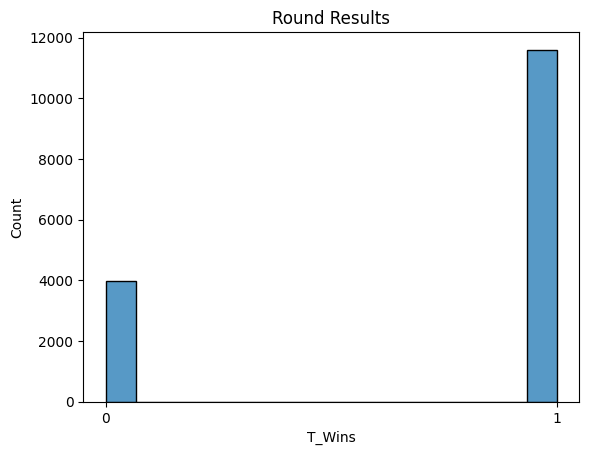

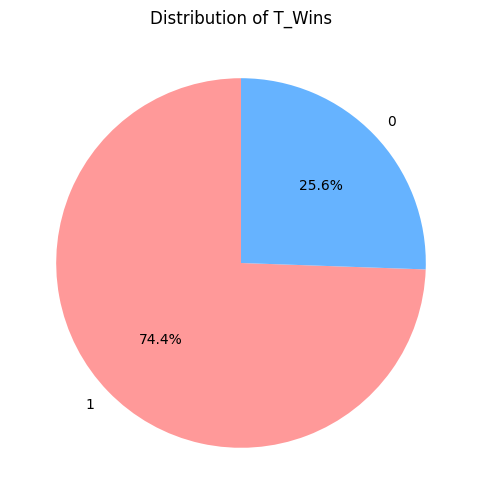

In [14]:
sns.histplot(df['T_Wins'], kde=False)
plt.title('Round Results')
plt.xticks([0, 1])
plt.show()

win_counts = df['T_Wins'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(win_counts, labels=win_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Distribution of T_Wins')
plt.show()